高频词：
剧情: 3349
第三章: 2037
欣欣: 2026
现实: 1884
支持: 1819
结局: 1715
情感: 1419
第一章: 1379
希望: 1314
不错: 1237
好评: 1121
导演: 1114
男主: 1072
社会: 1016
恋爱: 1014
作品: 989
选择: 984
反诈: 962
女性: 943
演技: 910


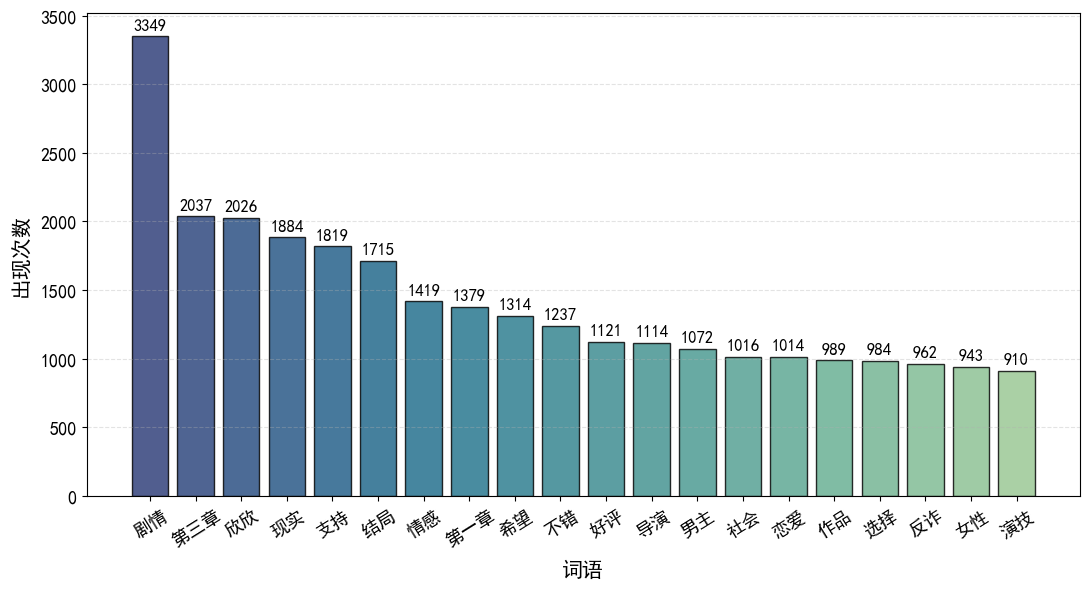

In [18]:
import pandas as pd
import jieba
from collections import Counter
import matplotlib.pyplot as plt
import re
import seaborn as sns


plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 读取评论数据
df = pd.read_csv('steam_reviews.csv')
df_cn = df[df['language'] == 'schinese'].copy()

# 合并所有评论文本
all_text = ' '.join(df_cn['review'].dropna().astype(str).tolist())

# 读取停用词表
with open('stopwords1893.txt', encoding='utf-8') as f:
    stopwords = set(line.strip() for line in f)

# 加入自定义停用词
stopwords.update(["感觉", "真的","游戏"," "])

# jieba分词
words = jieba.lcut(all_text, cut_all=False)

# 去除停用词和单字
filtered_words = [
    w for w in words
    if w not in stopwords and len(w) > 1 and re.search('[\u4e00-\u9fa5A-Za-z0-9]', w)
]

# 词频统计
word_counts = Counter(filtered_words)

# 输出前20高频词
top_n = 20
most_common_words = word_counts.most_common(top_n)
print("高频词：")
for word, count in most_common_words:
    print(f"{word}: {count}")

colors = sns.color_palette("crest", n_colors=len(words_))[::-1]
# 可视化
plt.figure(figsize=(11,6))
bars = plt.bar(words_, counts, 
              color=colors, 
               edgecolor='black', alpha=0.82, width=0.8)

# 添加数值标签
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height()+max(counts)*0.01,   # 适当调整偏移
             str(count), ha='center', va='bottom', fontsize=12, fontweight='semibold')

# plt.title("高频词统计", fontsize=18, fontweight='bold', pad=12)
plt.xlabel("词语", fontsize=15, fontweight='semibold', labelpad=8)
plt.ylabel("出现次数", fontsize=15, fontweight='semibold', labelpad=8)
plt.xticks(rotation=32, fontsize=13, fontweight='medium')
plt.yticks(fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()


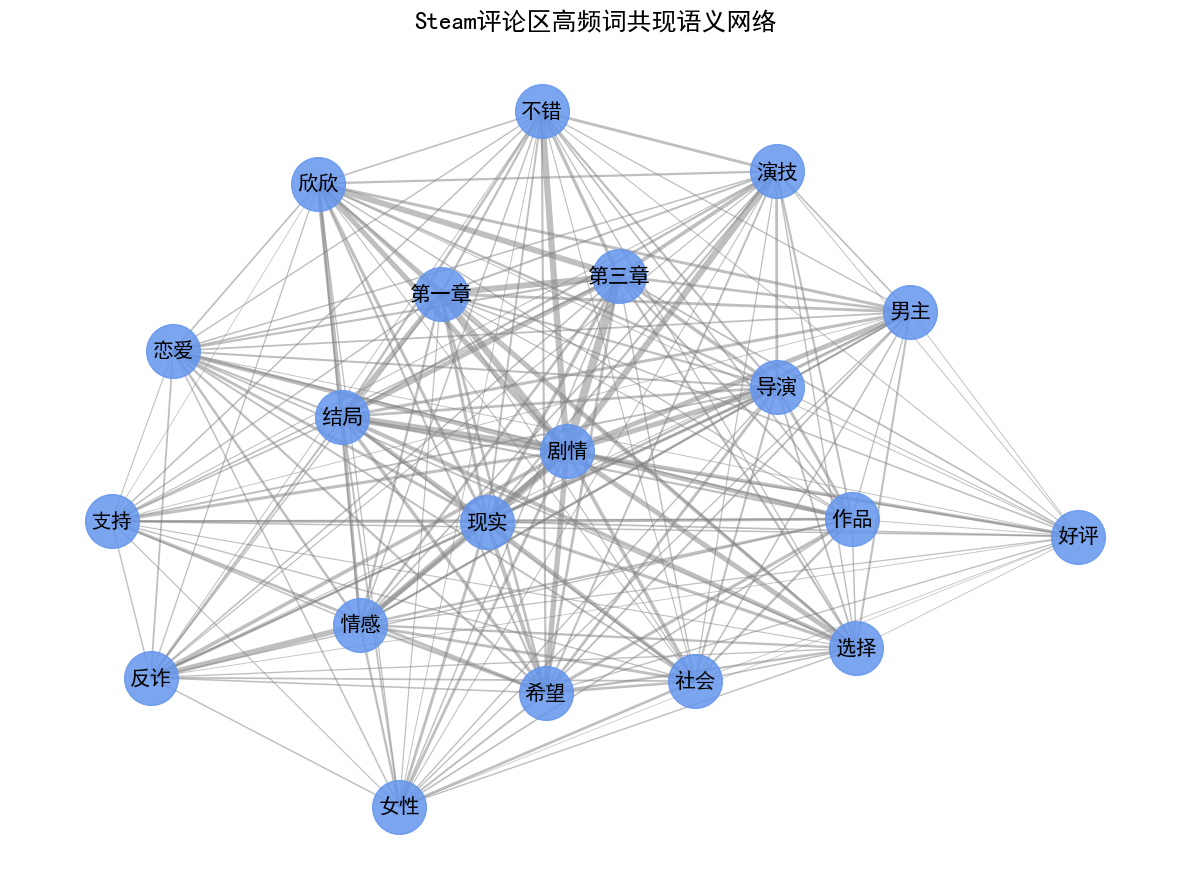

In [22]:
import pandas as pd
import jieba
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import networkx as nx

# 读取数据
df = pd.read_csv('steam_reviews.csv')
df_cn = df[df['language'] == 'schinese'].copy()

# 读取停用词
with open('stopwords1893.txt', encoding='utf-8') as f:
    stopwords = set(line.strip() for line in f)
stopwords.update(["感觉", "真的","游戏"," "])
# 合并所有评论文本，分句
sentences = df_cn['review'].dropna().astype(str).tolist()

# 先做词频，提取top20高频词
all_text = ' '.join(sentences)
words = jieba.lcut(all_text, cut_all=False)
# 去除停用词和单字
filtered_words = [
    w for w in words
    if w not in stopwords and len(w) > 1 and re.search('[\u4e00-\u9fa5A-Za-z0-9]', w)
]
word_counts = Counter(filtered_words)
top_n = 20
top_words = [w for w, _ in word_counts.most_common(top_n)]

# 统计高频词对的共现次数（以一句为窗口）
pair_counter = Counter()
for text in sentences:
    tokens = [w for w in jieba.lcut(str(text)) if w in top_words]
    unique_tokens = set(tokens)
    for w1 in unique_tokens:
        for w2 in unique_tokens:
            if w1 != w2:
                pair = tuple(sorted([w1, w2]))
                pair_counter[pair] += 1

# 构建网络
G = nx.Graph()
G.add_nodes_from(top_words)
for (w1, w2), count in pair_counter.items():
    if count > 10:  # 共现阈值
        G.add_edge(w1, w2, weight=count)

# 可视化
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G, k=0.42, seed=42)
edges = G.edges(data=True)
edge_weights = [e[2]['weight']/max([e[2]['weight'] for e in edges]) * 6 for e in edges]  # 线宽归一化

nx.draw_networkx_nodes(G, pos, node_color='#6495ED', node_size=1500, alpha=0.85)
nx.draw_networkx_labels(G, pos, font_family='SimHei', font_size=15, font_weight='bold', font_color='black')
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color='grey')

plt.title("Steam评论区高频词共现语义网络", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba
import re
# 读取数据
df = pd.read_csv('steam_reviews.csv')
df_cn = df[df['language'] == 'schinese'].copy()

# 读取停用词表
with open('stopwords1893.txt', encoding='utf-8') as f:
    stopwords = set(line.strip() for line in f)
stopwords.update(["感觉", "真的","游戏"," "])
# 分词+去除停用词的分词函数
def jieba_tokenizer(text):
    return [w for w in jieba.lcut(str(text)) if w not in stopwords and len(w) > 1 and re.search('[\u4e00-\u9fa5A-Za-z0-9]', w)]

# 拼接分词后的文本
docs_tokenized = [' '.join(jieba_tokenizer(text)) for text in df_cn['review'].fillna('')]

# TF-IDF模型
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x.split(), # 上面已经分好词
    lowercase=False
)
tfidf = vectorizer.fit_transform(docs_tokenized)
words = vectorizer.get_feature_names_out()

# 提取每条评论TF-IDF最高的前5关键词
topn = 5
tfidf_top_words = []
for i in range(tfidf.shape[0]):
    row = tfidf.getrow(i)
    top_idx = row.toarray().flatten().argsort()[-topn:][::-1]
    top_words = [words[j] for j in top_idx if row[0,j] > 0]
    tfidf_top_words.append(top_words)

# 加入原表格
df_cn['tfidf_top_words'] = tfidf_top_words

# 随机展示5条评论及其代表性关键词
for idx, row in df_cn[['review', 'tfidf_top_words']].sample(5, random_state=42).iterrows():
    print(f"评论：{row['review'][:80]}…")
    print(f"TF-IDF代表词：{', '.join(row['tfidf_top_words'])}")
    print("-"*60)


d:\python310\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


评论：哪怕做得不尽如人意，但，有勇气踏出那一步，终归是好的…
TF-IDF代表词：踏出, 终归是, 一步, 勇气
------------------------------------------------------------
评论：不为别的，愿世界再无胖猫......…
TF-IDF代表词：胖猫, 世界
------------------------------------------------------------
评论：好游戏!!!…
TF-IDF代表词：
------------------------------------------------------------
评论：且不提第三章的封神演出，我发现游戏里有“恋爱档案”这一部分，里面都是一些建立正确恋爱观价值观的干货。
我十年前学PUA的时候（那个时候PUA还不是现在这么声名狼…
TF-IDF代表词：PUA, 错过, 干货, 前学, 声名狼藉
------------------------------------------------------------
评论：咱现在库里有了这游戏，算不算打了捞女疫苗，将来不会有捞女这种拟人玩意接近咱了。

话说，这算是另类的黄油里处女通关和全CG通关的区别吗，让玩家去选明知有坑的选项…
TF-IDF代表词：黄油, CG, spoiler, 谏言, 玩外
------------------------------------------------------------


全体评论区分性最强的20个关键词（TF-IDF均值最高）:
欣欣: 0.0237
好玩: 0.0236
支持: 0.0229
第三章: 0.0193
剧情: 0.0187
不错: 0.0180
好评: 0.0174
现实: 0.0119
DLC: 0.0095
结局: 0.0094
第一章: 0.0090
推荐: 0.0086
值得: 0.0085
希望: 0.0083
封神: 0.0079
演技: 0.0077
导演: 0.0076
反诈: 0.0074
神作: 0.0073
多言: 0.0072


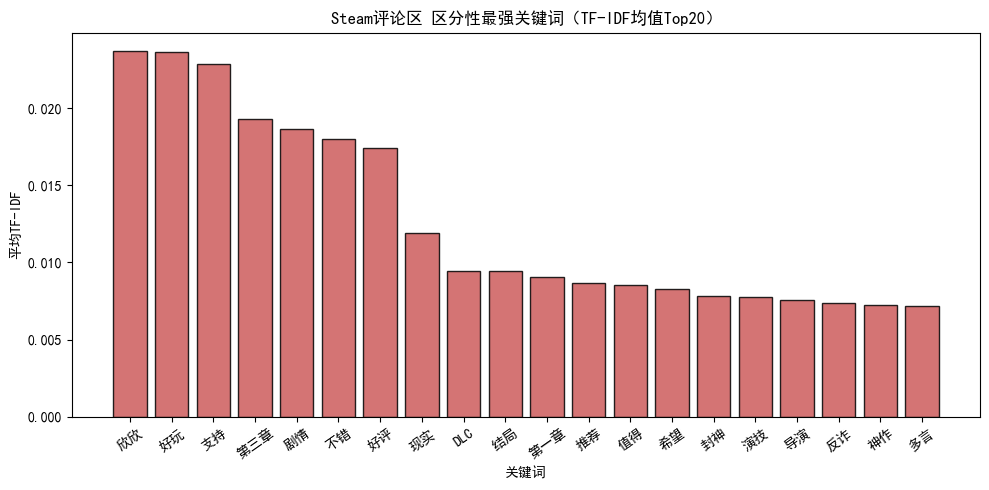

In [25]:
import numpy as np

# 计算每个词的tfidf均值
word_tfidf_mean = np.asarray(tfidf.mean(axis=0)).flatten()
top_indices = word_tfidf_mean.argsort()[-20:][::-1]
top_tfidf_words = [words[i] for i in top_indices]
top_tfidf_scores = [word_tfidf_mean[i] for i in top_indices]

# 输出结果
print("全体评论区分性最强的20个关键词（TF-IDF均值最高）:")
for w, s in zip(top_tfidf_words, top_tfidf_scores):
    print(f"{w}: {s:.4f}")

# 可视化
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(top_tfidf_words, top_tfidf_scores, color='indianred', alpha=0.85, edgecolor='k')
plt.title("Steam评论区 区分性最强关键词（TF-IDF均值Top20）")
plt.xlabel("关键词")
plt.ylabel("平均TF-IDF")
plt.xticks(rotation=35)
plt.tight_layout()
plt.show()
